# Train car 3

## train ready

In [30]:
import sys
import pandas as pd

from keras.applications import mobilenetv2
from keras.preprocessing import image
# import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Input, Model

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [31]:
modelpath='car.h5'
cache=False
basedir = './'

x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [32]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [33]:
imgwidth=224
imgheight=224

In [34]:
x_train = x_trainall[:7000]
y_train = y_trainall[:7000]
x_val = x_trainall[7000:]
y_val = y_trainall[7000:]
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

(7000, 224, 224, 3) (7000,) (2990, 224, 224, 3) (2990,)
0 195


In [35]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [36]:
# Image Augumentation
batch_size=64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=True)

In [37]:
# checkpoint save weights in progress...
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
checkpoint_path='ckpt/check_{epoch:04d}.ckpt'
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, period=10)

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [38]:
force = False

if os.path.exists(modelpath) and force==False :
    cache=True
    print('cache model use... continuous!')
else:
    cache=False
    print('no cache model. create new model!')

no cache model. create new model!


In [39]:
# model
if cache==True:
    model = load_model(modelpath)
    print('load model...')
else:
    inputs = Input(shape=(224,224,3))
    net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet', pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)

    model = Model(inputs=inputs, outputs=net2)
    print('new model...')
model.summary()

new model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________________________________________________________________________________________

In [40]:
if False:
    model.load_weights('ckpt/check_0180.ckpt')

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#epochs = 200
# hist = model.fit( x_train, y_train_onehot, batch_size=50, shuffle=True,  epochs=epochs, 
#                  verbose=1 , callbacks=[tensorboard], validation_data=[x_val, y_val_onehot] )
# 5, 
hist = model.fit_generator( train_generator, epochs = 500, validation_data=val_generator, 
                           callbacks=[cp_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Epoch 1/500
 57/109 [==============>...............] - ETA: 22s - loss: 0.0332 - acc: 0.9926

In [ ]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
# or 
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

In [ ]:
model.save(modelpath)

In [45]:
# submission
x_test = np.load('x_test.npy')
predictions = model.predict( x_test/255. )
pdi = np.argmax(predictions, axis=1)
print(pdi, np.min(pdi), np.max(pdi))

[123  97 156 ...  43  49  93] 0 195


In [46]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


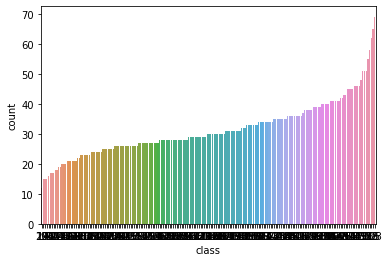

In [47]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)